#Database preparation

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Project/dataset/train.csv')

In [56]:
df.tail(10)

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,max_rain_mm_prev14d,min_rain_mm_prev14d,mean_rain_mm_prev14d,max_humidity_prev14d,min_humidity_prev14d,mean_humidity_prev14d,max_wind_speed_prev14d,min_wind_speed_prev14d,mean_wind_speed_prev14d,max_pressure_prev14d,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff
621290,2020-01-25,1,0,0,0,7.0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0,0.57,1.0,0.0,0.67,1.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,78.57,85.0,66.0,76.67,82.0,66.0,4.86,7.0,3.0,...,0.0,0.0,0.000,85.0,66.0,78.000,9.0,3.0,5.285,1044.0,1026.0,1031.790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,25,1,5.57,0.0,4.04,0.0,82.86,0.0,10.71,0.0,1015.86,0.0
621291,2020-01-26,1,0,0,0,7.0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0,0.86,3.0,0.0,1.67,3.0,1.0,0.00,0.0,0.0,0.00,0.0,0.0,76.86,85.0,60.0,69.33,82.0,60.0,5.14,7.0,4.0,...,0.0,0.0,0.000,85.0,60.0,76.500,9.0,3.0,5.285,1044.0,1025.0,1031.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,26,1,6.14,0.0,5.31,0.0,82.71,0.0,11.86,0.0,1014.71,0.0
621292,2020-01-27,1,0,0,0,7.0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0,1.86,7.0,0.0,3.67,7.0,1.0,0.00,0.0,0.0,0.00,0.0,0.0,76.43,85.0,60.0,68.00,78.0,60.0,5.43,7.0,4.0,...,0.0,0.0,0.000,85.0,60.0,76.000,9.0,3.0,5.430,1044.0,1023.0,1030.925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,27,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
621293,2020-01-28,1,0,0,0,7.0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0,2.43,7.0,0.0,5.00,7.0,3.0,2.60,18.2,0.0,6.07,18.2,0.0,78.14,94.0,60.0,77.33,94.0,60.0,5.43,7.0,4.0,...,18.2,0.0,1.300,94.0,60.0,76.855,9.0,3.0,5.500,1044.0,1018.0,1030.215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,28,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
621294,2020-01-29,1,0,0,0,7.0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0,3.29,7.0,0.0,6.00,7.0,5.0,2.77,18.2,0.0,6.47,18.2,0.0,77.86,94.0,60.0,85.00,94.0,78.0,7.00,15.0,4.0,...,18.2,0.0,1.385,94.0,60.0,76.930,15.0,3.0,6.145,1044.0,1011.0,1029.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
621295,2020-01-30,1,0,0,0,7.0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0,4.00,7.0,1.0,5.33,6.0,5.0,3.57,18.2,0.0,8.33,18.2,1.2,77.71,94.0,60.0,86.00,94.0,81.0,8.14,15.0,5.0,...,18.2,0.0,1.785,94.0,60.0,77.500,15.0,3.0,6.355,1044.0,1010.0,1027.640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,30,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
621296,2020-01-31,1,0,0,0,7.0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0,4.29,7.0,1.0,

In [3]:
#Prima di eseguire questo script sarebbe opportuno controllare che le date sono ordinate in ordine crescente

weather_names =['_temperature_','_rain_mm_','_humidity_','_wind_speed_','_pressure_']

for name in weather_names:
  df['max'+name+'prev14d']=df['max'+name+'prev7d']
  df['max'+name+'prev7d_shift']=df['max'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df['DATE']>'2019-04-16', 'max'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['max'+name+'prev7d','max'+name+'prev7d_shift']].max(axis=1)
  df=df.drop(columns=['max'+name+'prev7d_shift'])

  df['min'+name+'prev14d']=df['min'+name+'prev7d']
  df['min'+name+'prev7d_shift']=df['min'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', 'min'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['min'+name+'prev7d','min'+name+'prev7d_shift']].min(axis=1)
  df=df.drop(columns=['min'+name+'prev7d_shift'])

  df['mean'+name+'prev14d']=df['mean'+name+'prev7d']
  df['mean'+name+'prev7d_shift']=df['mean'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', 'mean'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['mean'+name+'prev7d','mean'+name+'prev7d_shift']].mean(axis=1)
  df=df.drop(columns=['mean'+name+'prev7d_shift'])

persistance_names =['equipment','fire/smoke','ge','power','temperature']

for name in persistance_names:
  df[name+'_max_persistance_prev14d']=df[name+'_max_persistance_prev7d']
  df[name+'_max_persistance_prev7d_shift']=df[name+'_max_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_max_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_max_persistance_prev7d',name+'_max_persistance_prev7d_shift']].max(axis=1)
  df=df.drop(columns=[name+'_max_persistance_prev7d_shift'])
  
  df[name+'_min_persistance_prev14d']=df[name+'_min_persistance_prev7d']
  df[name+'_min_persistance_prev7d_shift']=df[name+'_min_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_min_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_min_persistance_prev7d',name+'_min_persistance_prev7d_shift']].min(axis=1)
  df=df.drop(columns=[name+'_min_persistance_prev7d_shift'])

  df[name+'_mean_persistance_prev14d']=df[name+'_mean_persistance_prev7d']
  df[name+'_mean_persistance_prev7d_shift']=df[name+'_mean_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_mean_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_mean_persistance_prev7d',name+'_mean_persistance_prev7d_shift']].mean(axis=1)
  df=df.drop(columns=[name+'_mean_persistance_prev7d_shift'])

In [4]:
#drop unused columns
df = df.drop(columns='CELL_TYPE_TRP')
df = df.drop(columns='SITE_ID')

#process data feature
df['DATE'] = pd.to_datetime(df['DATE'])
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day
df['year'] = df['DATE'].dt.year % 2019
#df = df.drop(columns='DATE')

In [5]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,25))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#Diff PREV7-NEXT7 grouped

In [ ]:
#adding cluster string label
geo_cols = [col for col in df.columns if 'GEOGRAPHIC_CLUSTER_K_' in col]
df_geo=df[geo_cols];

df['cluster_class']=df_geo.idxmax(1)

In [ ]:
df_cluster_date_group = df.groupby(['cluster_class', 'DATE']).mean().reset_index()

In [ ]:
df_cluster_date_group['mean_temperature_prev7d_shift']=df_cluster_date_group['mean_temperature_prev7d'].shift(-8, axis = 0)
df_cluster_date_group['mean_temperature_prev7d_diff']=df_cluster_date_group['mean_temperature_prev7d_shift']-df_cluster_date_group['mean_temperature_f_next7d']

[Text(0.5, 1.0, "(0       0.0\n1       0.0\n2       0.0\n3       0.0\n4       0.0\n       ... \n2995    NaN\n2996    NaN\n2997    NaN\n2998    NaN\n2999    NaN\nName: mean_temperature_prev7d_diff, Length: 3000, dtype: float64, ' Trend')")]

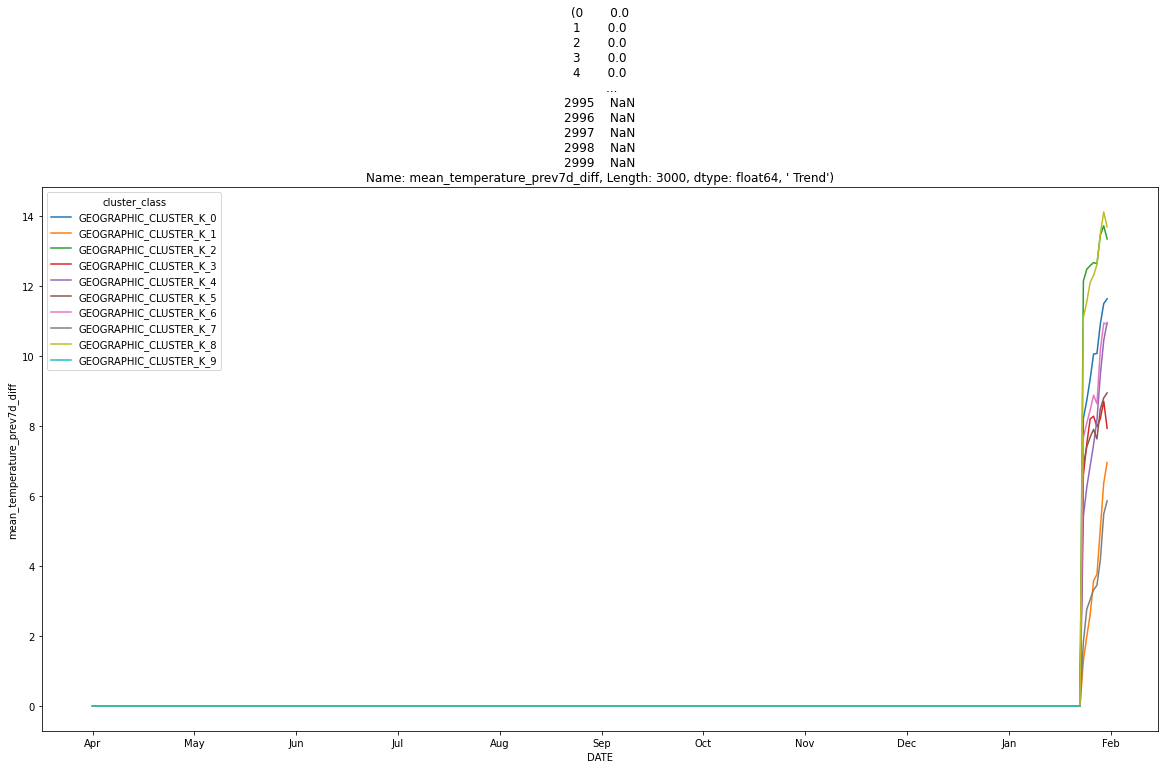

In [ ]:
var=df_cluster_date_group['mean_temperature_prev7d_diff'];
plt.figure(figsize=(20,10))
plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300], ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb']);
sns.lineplot(data=df_cluster_date_group, x='DATE', y=var, hue='cluster_class').set(title=(var,' Trend'))

In [ ]:
df_cluster_date_group['mean_rain_mm_prev7d_shift']=df_cluster_date_group['mean_rain_mm_prev7d'].shift(-8, axis = 0)
df_cluster_date_group['mean_rain_mm_prev7d_diff']=df_cluster_date_group['mean_rain_mm_prev7d_shift']-df_cluster_date_group['mean_rain_mm_f_next7d']

[Text(0.5, 1.0, "(0       0.0\n1       0.0\n2       0.0\n3       0.0\n4       0.0\n       ... \n2995    NaN\n2996    NaN\n2997    NaN\n2998    NaN\n2999    NaN\nName: mean_rain_mm_prev7d_diff, Length: 3000, dtype: float64, ' Trend')")]

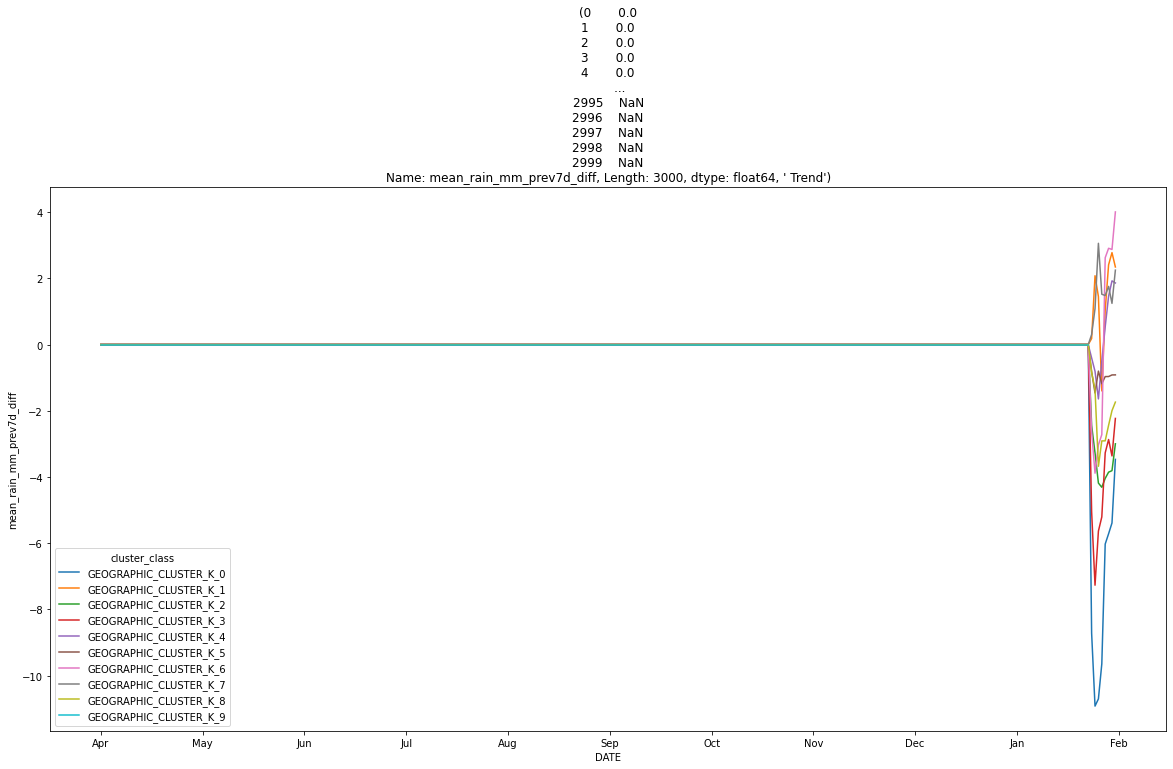

In [ ]:
var=df_cluster_date_group['mean_rain_mm_prev7d_diff']
plt.figure(figsize=(20,10))
plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300], ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb']);
sns.lineplot(data=df_cluster_date_group, x='DATE', y=var, hue='cluster_class').set(title=(var,' Trend'))

In [ ]:
df_cluster_date_group['mean_humidity_prev7d_shift']=df_cluster_date_group['mean_humidity_prev7d'].shift(-8, axis = 0)
df_cluster_date_group['mean_humidity_prev7d_diff']=df_cluster_date_group['mean_humidity_prev7d_shift']-df_cluster_date_group['mean_humidity_f_next7d']

[Text(0.5, 1.0, "(0       0.0\n1       0.0\n2       0.0\n3       0.0\n4       0.0\n       ... \n2995    NaN\n2996    NaN\n2997    NaN\n2998    NaN\n2999    NaN\nName: mean_humidity_prev7d_diff, Length: 3000, dtype: float64, ' Trend')")]

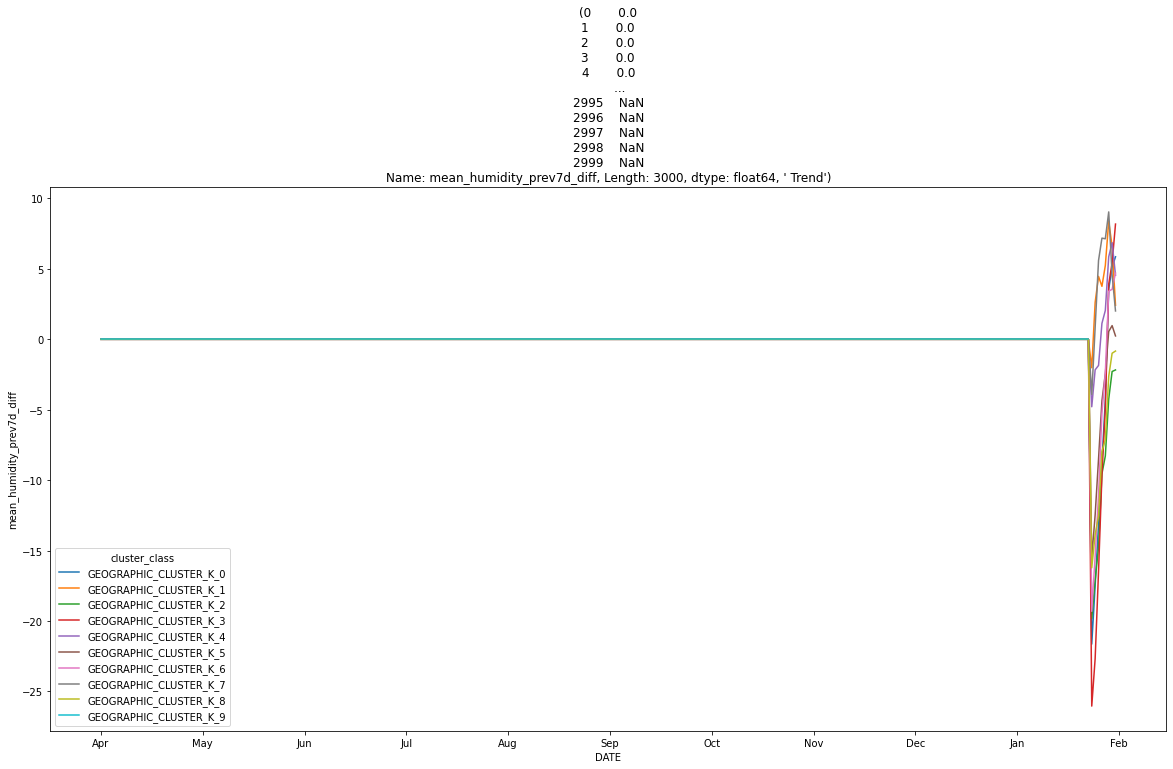

In [ ]:
var=df_cluster_date_group['mean_humidity_prev7d_diff']
plt.figure(figsize=(20,10))
plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300], ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb']);
sns.lineplot(data=df_cluster_date_group, x='DATE', y=var, hue='cluster_class').set(title=(var,' Trend'))

In [ ]:
df_cluster_date_group['mean_wind_speed_prev7d_shift']=df_cluster_date_group['mean_wind_speed_prev7d'].shift(-8, axis = 0)
df_cluster_date_group['mean_wind_speed_prev7d_diff']=df_cluster_date_group['mean_wind_speed_prev7d_shift']-df_cluster_date_group['mean_wind_speed_f_next7d']

[Text(0.5, 1.0, "(0       0.0\n1       0.0\n2       0.0\n3       0.0\n4       0.0\n       ... \n2995    NaN\n2996    NaN\n2997    NaN\n2998    NaN\n2999    NaN\nName: mean_wind_speed_prev7d_diff, Length: 3000, dtype: float64, ' Trend')")]

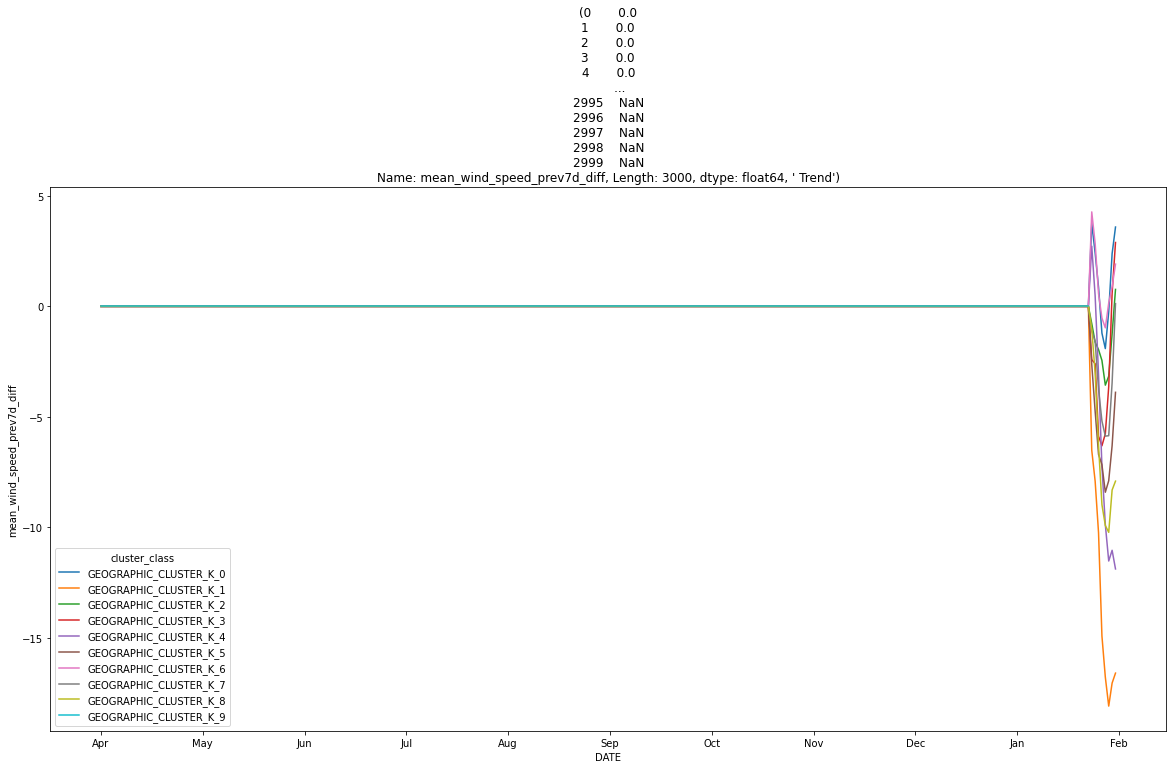

In [ ]:
var=df_cluster_date_group['mean_wind_speed_prev7d_diff']
plt.figure(figsize=(20,10))
plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300], ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb']);
sns.lineplot(data=df_cluster_date_group, x='DATE', y=var, hue='cluster_class').set(title=(var,' Trend'))

In [ ]:
df_cluster_date_group['mean_pressure_prev7d_shift']=df_cluster_date_group['mean_pressure_prev7d'].shift(-8, axis = 0)
df_cluster_date_group['mean_pressure_prev7d_diff']=df_cluster_date_group['mean_pressure_prev7d_shift']-df_cluster_date_group['mean_pressure_f_next7d']

[Text(0.5, 1.0, "(0       0.0\n1       0.0\n2       0.0\n3       0.0\n4       0.0\n       ... \n2995    NaN\n2996    NaN\n2997    NaN\n2998    NaN\n2999    NaN\nName: mean_pressure_prev7d_diff, Length: 3000, dtype: float64, ' Trend')")]

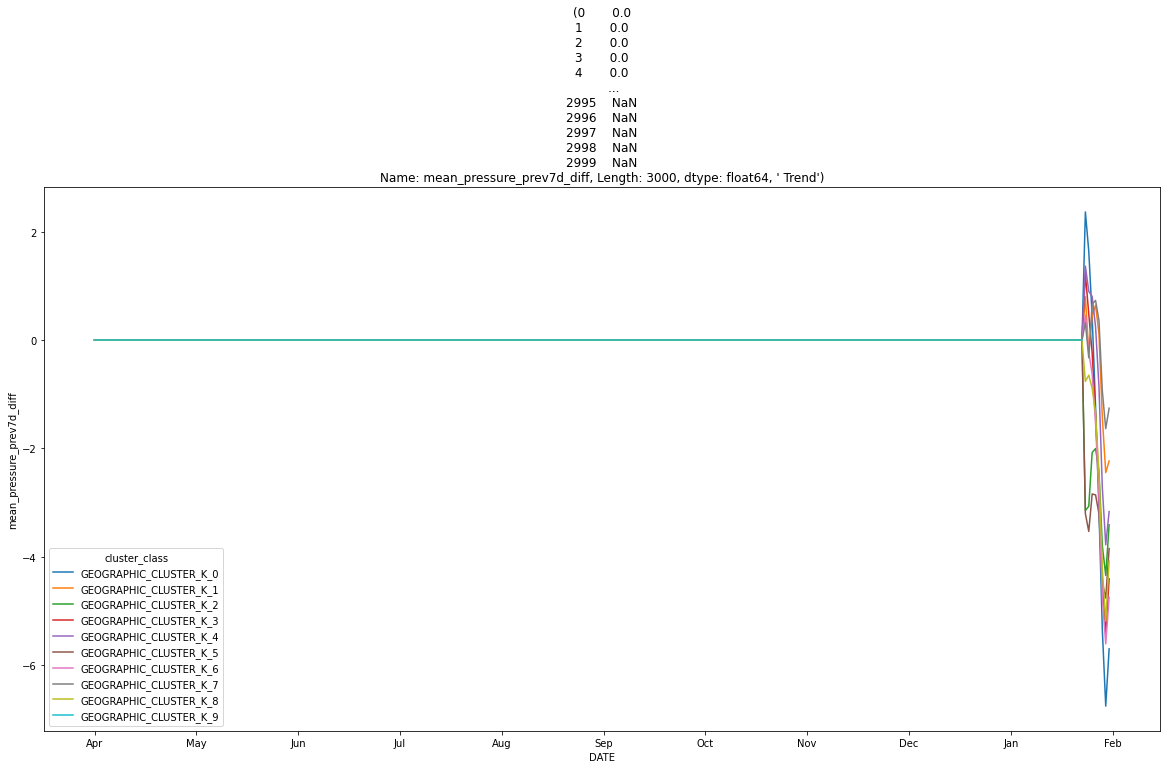

In [ ]:
var=df_cluster_date_group['mean_pressure_prev7d_diff']
plt.figure(figsize=(20,10))
plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300], ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb']);
sns.lineplot(data=df_cluster_date_group, x='DATE', y=var, hue='cluster_class').set(title=(var,' Trend'))

#Diff PREV7-NEXT7 

In [ ]:
df_cluster_date = df.groupby(['cluster_class', 'DATE']).mean().reset_index()

In [ ]:
name = ['_temperature_','_rain_mm_','_humidity_','_wind_speed_','_pressure_']

In [30]:
df['mean_temperature_prev7d_shift']=df['mean_temperature_prev7d'].shift(-8, axis = 0)
df['mean_temperature_prev7d_diff']=df['mean_temperature_prev7d_shift']-df['mean_temperature_f_next7d']

df['mean_rain_mm_prev7d_shift']=df['mean_rain_mm_prev7d'].shift(-8, axis = 0)
df['mean_rain_mm_prev7d_diff']=df['mean_rain_mm_prev7d_shift']-df['mean_rain_mm_f_next7d']

df['mean_humidity_prev7d_shift']=df['mean_humidity_prev7d'].shift(-8, axis = 0)
df['mean_humidity_prev7d_diff']=df['mean_humidity_prev7d_shift']-df['mean_humidity_f_next7d']

df['mean_wind_speed_prev7d_shift']=df['mean_wind_speed_prev7d'].shift(-8, axis = 0)
df['mean_wind_speed_prev7d_diff']=df['mean_wind_speed_prev7d_shift']-df['mean_wind_speed_f_next7d']

df['mean_pressure_prev7d_shift']=df['mean_pressure_prev7d'].shift(-8, axis = 0)
df['mean_pressure_prev7d_diff']=df['mean_pressure_prev7d_shift']-df['mean_pressure_f_next7d']

[Text(0.5, 1.0, "(0         0.0\n1         0.0\n2         0.0\n3         0.0\n4         0.0\n         ... \n621295    NaN\n621296    NaN\n621297    NaN\n621298    NaN\n621299    NaN\nName: mean_temperature_prev7d_diff, Length: 621300, dtype: float64, ' Trend')")]

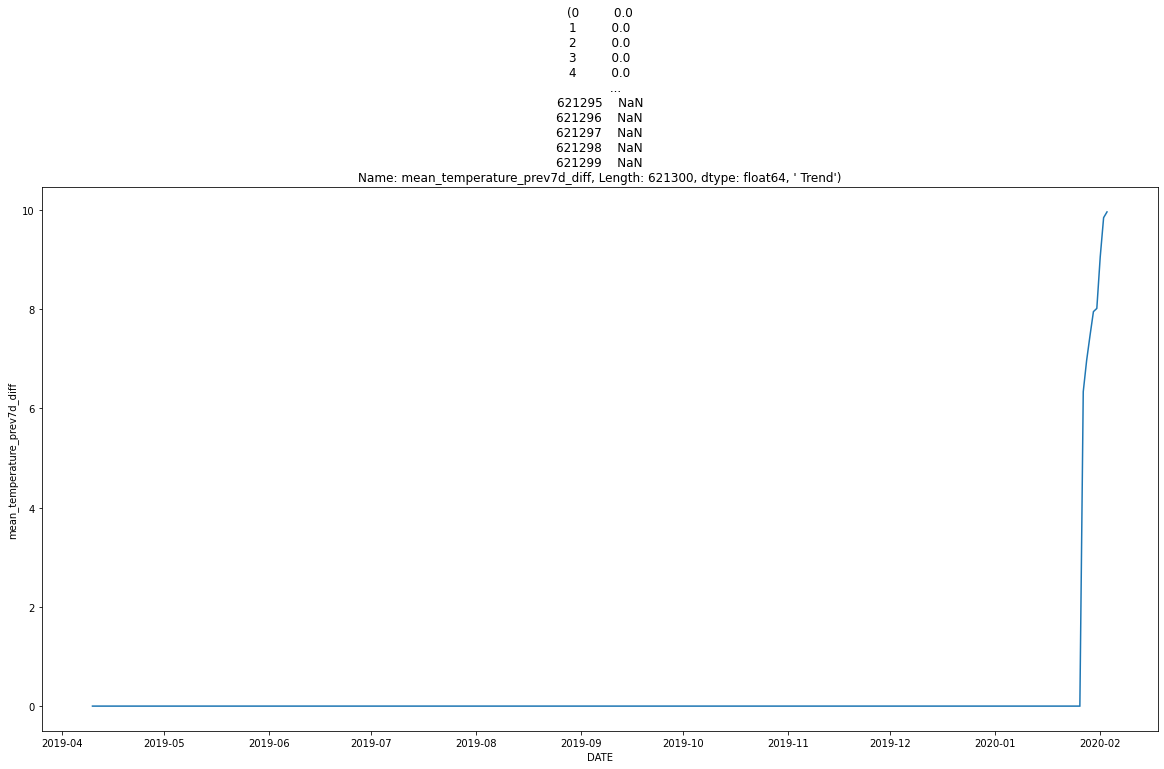

In [21]:
var=df['mean_temperature_prev7d_diff']
plt.figure(figsize=(20,10))
#plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300], ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb']);
sns.lineplot(data=df, x='DATE', y=var).set(title=(var,' Trend'))

In [58]:
df[(df['mean_temperature_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,max_rain_mm_prev14d,min_rain_mm_prev14d,mean_rain_mm_prev14d,max_humidity_prev14d,min_humidity_prev14d,mean_humidity_prev14d,max_wind_speed_prev14d,min_wind_speed_prev14d,mean_wind_speed_prev14d,max_pressure_prev14d,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff


In [59]:
df[(df['mean_rain_mm_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,max_rain_mm_prev14d,min_rain_mm_prev14d,mean_rain_mm_prev14d,max_humidity_prev14d,min_humidity_prev14d,mean_humidity_prev14d,max_wind_speed_prev14d,min_wind_speed_prev14d,mean_wind_speed_prev14d,max_pressure_prev14d,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff


In [60]:
df[(df['mean_humidity_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,max_rain_mm_prev14d,min_rain_mm_prev14d,mean_rain_mm_prev14d,max_humidity_prev14d,min_humidity_prev14d,mean_humidity_prev14d,max_wind_speed_prev14d,min_wind_speed_prev14d,mean_wind_speed_prev14d,max_pressure_prev14d,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff


In [61]:
df[(df['mean_wind_speed_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,max_rain_mm_prev14d,min_rain_mm_prev14d,mean_rain_mm_prev14d,max_humidity_prev14d,min_humidity_prev14d,mean_humidity_prev14d,max_wind_speed_prev14d,min_wind_speed_prev14d,mean_wind_speed_prev14d,max_pressure_prev14d,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff


In [62]:
df[(df['mean_pressure_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,max_rain_mm_prev14d,min_rain_mm_prev14d,mean_rain_mm_prev14d,max_humidity_prev14d,min_humidity_prev14d,mean_humidity_prev14d,max_wind_speed_prev14d,min_wind_speed_prev14d,mean_wind_speed_prev14d,max_pressure_prev14d,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff


In [70]:
df['max_temperature_prev7d_shift']=df['max_temperature_prev7d'].shift(-8, axis = 0)
df['max_temperature_prev7d_diff']=df['max_temperature_prev7d_shift']-df['max_temperature_f_next7d']

df['max_rain_mm_prev7d_shift']=df['max_rain_mm_prev7d'].shift(-8, axis = 0)
df['max_rain_mm_prev7d_diff']=df['max_rain_mm_prev7d_shift']-df['max_rain_mm_f_next7d']

df['max_humidity_prev7d_shift']=df['max_humidity_prev7d'].shift(-8, axis = 0)
df['max_humidity_prev7d_diff']=df['max_humidity_prev7d_shift']-df['max_humidity_f_next7d']

df['max_wind_speed_prev7d_shift']=df['max_wind_speed_prev7d'].shift(-8, axis = 0)
df['max_wind_speed_prev7d_diff']=df['max_wind_speed_prev7d_shift']-df['max_wind_speed_f_next7d']

df['max_pressure_prev7d_shift']=df['max_pressure_prev7d'].shift(-8, axis = 0)
df['max_pressure_prev7d_diff']=df['max_pressure_prev7d_shift']-df['max_pressure_f_next7d']

In [71]:
df[(df['max_temperature_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff,max_temperature_prev7d_shift,max_temperature_prev7d_diff,max_rain_mm_prev7d_shift,max_rain_mm_prev7d_diff,max_humidity_prev7d_shift,max_humidity_prev7d_diff,max_wind_speed_prev7d_shift,max_wind_speed_prev7d_diff,max_pressure_prev7d_shift,max_pressure_prev7d_diff


In [72]:
df[(df['max_rain_mm_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff,max_temperature_prev7d_shift,max_temperature_prev7d_diff,max_rain_mm_prev7d_shift,max_rain_mm_prev7d_diff,max_humidity_prev7d_shift,max_humidity_prev7d_diff,max_wind_speed_prev7d_shift,max_wind_speed_prev7d_diff,max_pressure_prev7d_shift,max_pressure_prev7d_diff


In [73]:
df[(df['max_humidity_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff,max_temperature_prev7d_shift,max_temperature_prev7d_diff,max_rain_mm_prev7d_shift,max_rain_mm_prev7d_diff,max_humidity_prev7d_shift,max_humidity_prev7d_diff,max_wind_speed_prev7d_shift,max_wind_speed_prev7d_diff,max_pressure_prev7d_shift,max_pressure_prev7d_diff


In [74]:
df[(df['max_wind_speed_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff,max_temperature_prev7d_shift,max_temperature_prev7d_diff,max_rain_mm_prev7d_shift,max_rain_mm_prev7d_diff,max_humidity_prev7d_shift,max_humidity_prev7d_diff,max_wind_speed_prev7d_shift,max_wind_speed_prev7d_diff,max_pressure_prev7d_shift,max_pressure_prev7d_diff


In [75]:
df[(df['max_pressure_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff,max_temperature_prev7d_shift,max_temperature_prev7d_diff,max_rain_mm_prev7d_shift,max_rain_mm_prev7d_diff,max_humidity_prev7d_shift,max_humidity_prev7d_diff,max_wind_speed_prev7d_shift,max_wind_speed_prev7d_diff,max_pressure_prev7d_shift,max_pressure_prev7d_diff


In [78]:
df['min_temperature_prev7d_shift']=df['min_temperature_prev7d'].shift(-8, axis = 0)
df['min_temperature_prev7d_diff']=df['min_temperature_prev7d_shift']-df['min_temperature_f_next7d']

df['min_rain_mm_prev7d_shift']=df['min_rain_mm_prev7d'].shift(-8, axis = 0)
df['min_rain_mm_prev7d_diff']=df['min_rain_mm_prev7d_shift']-df['min_rain_mm_f_next7d']

df['min_humidity_prev7d_shift']=df['min_humidity_prev7d'].shift(-8, axis = 0)
df['min_humidity_prev7d_diff']=df['min_humidity_prev7d_shift']-df['min_humidity_f_next7d']

df['min_wind_speed_prev7d_shift']=df['min_wind_speed_prev7d'].shift(-8, axis = 0)
df['min_wind_speed_prev7d_diff']=df['min_wind_speed_prev7d_shift']-df['min_wind_speed_f_next7d']

df['min_pressure_prev7d_shift']=df['min_pressure_prev7d'].shift(-8, axis = 0)
df['min_pressure_prev7d_diff']=df['min_pressure_prev7d_shift']-df['min_pressure_f_next7d']

In [79]:
df[(df['min_temperature_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff,max_temperature_prev7d_shift,max_temperature_prev7d_diff,max_rain_mm_prev7d_shift,max_rain_mm_prev7d_diff,max_humidity_prev7d_shift,max_humidity_prev7d_diff,max_wind_speed_prev7d_shift,max_wind_speed_prev7d_diff,max_pressure_prev7d_shift,max_pressure_prev7d_diff,min_temperature_prev7d_shift,min_temperature_prev7d_diff,min_rain_mm_prev7d_shift,min_rain_mm_prev7d_diff,min_humidity_prev7d_shift,min_humidity_prev7d_diff,min_wind_speed_prev7d_shift,min_wind_speed_prev7d_diff,min_pressure_prev7d_shift,min_pressure_prev7d_diff


In [80]:
df[(df['min_rain_mm_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff,max_temperature_prev7d_shift,max_temperature_prev7d_diff,max_rain_mm_prev7d_shift,max_rain_mm_prev7d_diff,max_humidity_prev7d_shift,max_humidity_prev7d_diff,max_wind_speed_prev7d_shift,max_wind_speed_prev7d_diff,max_pressure_prev7d_shift,max_pressure_prev7d_diff,min_temperature_prev7d_shift,min_temperature_prev7d_diff,min_rain_mm_prev7d_shift,min_rain_mm_prev7d_diff,min_humidity_prev7d_shift,min_humidity_prev7d_diff,min_wind_speed_prev7d_shift,min_wind_speed_prev7d_diff,min_pressure_prev7d_shift,min_pressure_prev7d_diff


In [81]:
df[(df['min_pressure_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff,max_temperature_prev7d_shift,max_temperature_prev7d_diff,max_rain_mm_prev7d_shift,max_rain_mm_prev7d_diff,max_humidity_prev7d_shift,max_humidity_prev7d_diff,max_wind_speed_prev7d_shift,max_wind_speed_prev7d_diff,max_pressure_prev7d_shift,max_pressure_prev7d_diff,min_temperature_prev7d_shift,min_temperature_prev7d_diff,min_rain_mm_prev7d_shift,min_rain_mm_prev7d_diff,min_humidity_prev7d_shift,min_humidity_prev7d_diff,min_wind_speed_prev7d_shift,min_wind_speed_prev7d_diff,min_pressure_prev7d_shift,min_pressure_prev7d_diff


In [82]:
df[(df['min_humidity_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff,max_temperature_prev7d_shift,max_temperature_prev7d_diff,max_rain_mm_prev7d_shift,max_rain_mm_prev7d_diff,max_humidity_prev7d_shift,max_humidity_prev7d_diff,max_wind_speed_prev7d_shift,max_wind_speed_prev7d_diff,max_pressure_prev7d_shift,max_pressure_prev7d_diff,min_temperature_prev7d_shift,min_temperature_prev7d_diff,min_rain_mm_prev7d_shift,min_rain_mm_prev7d_diff,min_humidity_prev7d_shift,min_humidity_prev7d_diff,min_wind_speed_prev7d_shift,min_wind_speed_prev7d_diff,min_pressure_prev7d_shift,min_pressure_prev7d_diff


In [83]:
df[(df['min_wind_speed_prev7d_diff']>0) & (df['DATE']<'2020-01-27')].head()

,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,...,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,mean_temperature_prev7d_shift,mean_temperature_prev7d_diff,mean_rain_mm_prev7d_shift,mean_rain_mm_prev7d_diff,mean_humidity_prev7d_shift,mean_humidity_prev7d_diff,mean_wind_speed_prev7d_shift,mean_wind_speed_prev7d_diff,mean_pressure_prev7d_shift,mean_pressure_prev7d_diff,max_temperature_prev7d_shift,max_temperature_prev7d_diff,max_rain_mm_prev7d_shift,max_rain_mm_prev7d_diff,max_humidity_prev7d_shift,max_humidity_prev7d_diff,max_wind_speed_prev7d_shift,max_wind_speed_prev7d_diff,max_pressure_prev7d_shift,max_pressure_prev7d_diff,min_temperature_prev7d_shift,min_temperature_prev7d_diff,min_rain_mm_prev7d_shift,min_rain_mm_prev7d_diff,min_humidity_prev7d_shift,min_humidity_prev7d_diff,min_wind_speed_prev7d_shift,min_wind_speed_prev7d_diff,min_pressure_prev7d_shift,min_pressure_prev7d_diff
